# Collaborative Production

This notebook presents the numerical experiments for the paper [*Private Distributed Resource Allocation Without Constraint Violations*](https://ieeexplore.ieee.org/abstract/document/11120444).

# Communication topology

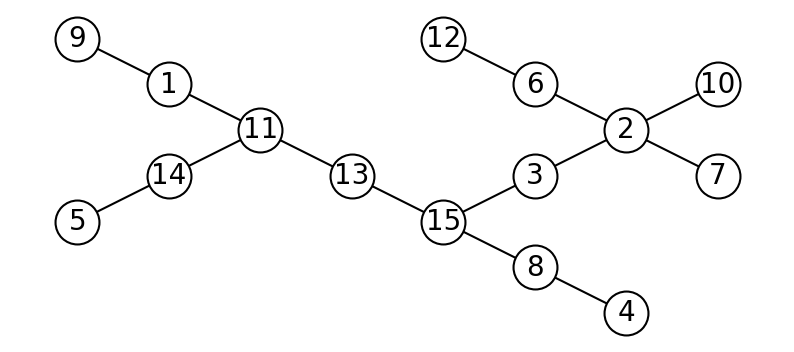

In [1]:
if __name__ == "__main__":
    NODES = [f"{i}" for i in range(1, 16)]
    EDGES = [
        ("1", "9"),
        ("1", "11"),
        ("2", "3"),
        ("2", "6"),
        ("2", "7"),
        ("2", "10"),
        ("6", "12"),
        ("3", "15"),
        ("4", "8"),
        ("5", "14"),
        ("8", "15"),
        ("11", "13"),
        ("11", "14"),
        ("13", "15"),
    ]

    import matplotlib.pyplot as plt
    import networkx as nx

    pos = {
        "1": [-3.0, 1.5],
        "2": [2.0, 1.0],
        "3": [1.0, 0.5],
        "4": [2.0, -1.0],
        "5": [-4.0, 0.0],
        "6": [1.0, 1.5],
        "7": [3.0, 0.5],
        "8": [1.0, -0.5],
        "9": [-4.0, 2.0],
        "10": [3.0, 1.5],
        "11": [-2.0, 1.0],
        "12": [0.0, 2.0],
        "13": [-1.0, 0.5],
        "14": [-3.0, 0.5],
        "15": [0.0, 0.0],
    }

    G = nx.Graph()
    G.add_nodes_from(NODES)
    G.add_edges_from(EDGES)

    nx_options = {
        "with_labels": True,
        "font_size": 20,
        "node_color": "white",
        "node_size": 1000,
        "edgecolors": "black",
        "linewidths": 1.5,
        "width": 1.5,
        "pos": pos,
    }

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_aspect("equal")
    nx.draw(G, ax=ax, **nx_options)

## Problem formulation:
$$
\begin{split}
    \max_{\boldsymbol{x}_{1}, \ldots, \boldsymbol{x}_{15}} &\left\{P(\boldsymbol{x}) = \sum_{i \in \mathcal{I}}\langle\boldsymbol{c}_{i}^{pro}, \boldsymbol{x}_{i}\rangle \right\}\\
    \text{s.t.}\quad &
    \begin{cases}
        \sum_{i \in \mathcal{I}}\langle \boldsymbol{a}_{i, 1}^{mat},\boldsymbol{x}_{i} \rangle \leq b_{1}^{mat}(D)   \\
        \sum_{i \in \mathcal{I}}\langle \boldsymbol{a}_{i, 2}^{mat},\boldsymbol{x}_{i} \rangle \leq b_{2}^{mat}(D)   \\
        \langle \boldsymbol{a}_{i, 1}^{lab},\boldsymbol{x}_{i} \rangle\leq b_{i, 1}^{lab}, \forall i \in \mathcal{I} \\
        \langle \boldsymbol{a}_{i, 2}^{lab},\boldsymbol{x}_{i} \rangle\leq b_{i, 2}^{lab}, \forall i \in \mathcal{I},
    \end{cases}
\end{split}
$$

In [2]:
if __name__ == "__main__":
    import pathlib

    data_dir = pathlib.Path.cwd() / "data"

    import numpy as np
    from numpy.typing import NDArray

    datas: dict[str, dict[str, NDArray[np.float64]]] = {
        i: np.load(data_dir / f"node_{i}.npz") for i in NODES
    }

    c_pro = {i: datas[i]["c_pro"] for i in NODES}
    A_mat = {i: datas[i]["A_mat"] for i in NODES}
    x_lab = {i: datas[i]["x_lab"] for i in NODES}

    b_mat: NDArray[np.float64] = np.load(data_dir / "b_mat.npy")

    import cvxpy as cp

    x = {i: cp.Variable(A_mat[i].shape[1]) for i in NODES}

    cost = cp.sum([-c_pro[i] @ x[i] for i in NODES])

    lab_constraints: list[cp.Constraint] = [x[i] - x_lab[i] <= 0 for i in NODES]
    mat_constraints: list[cp.Constraint] = [
        sum([A_mat[i] @ x[i] for i in NODES], start=cp.Constant(0)) - b_mat <= 0
    ]

    constraints = mat_constraints + lab_constraints

    problem = cp.Problem(cp.Minimize(cost), constraints)
    opt_val: float = problem.solve(solver="GLPK")  # type: ignore

    print(f"Optimal value: {opt_val}")

Optimal value: -62.837151677467475


## Private distributed optimization:

In [ ]:
def graph(nodes: list[str], edges: list[tuple[str, str]]) -> None:
    import logging

    logging.basicConfig(level=logging.INFO)

    from topolink import Graph

    graph = Graph(nodes, edges)

    graph.deploy()


def worker(
    node_idx: str,
    b: NDArray[np.float64] | None,
    max_iter: int = 7000,
    step_size: float = 10.0,
) -> dict[str, NDArray[np.float64]]:
    # Load local data
    import pathlib

    data_dir = pathlib.Path.cwd() / "data"
    data: dict[str, NDArray[np.float64]] = np.load(data_dir / f"node_{node_idx}.npz")

    c: NDArray[np.float64] = data["c_pro"]
    a: NDArray[np.float64] = data["A_mat"]
    x_ub: NDArray[np.float64] = data["x_lab"]

    # Define local objective and constraint functions
    import cvxpy as cp

    def f(x: cp.Expression) -> cp.Expression:
        return -c @ x

    def g(x: cp.Expression) -> cp.Expression:
        return x - x_ub

    # Define node handle
    from topolink import NodeHandle

    nh = NodeHandle(node_idx)

    # Initialize storage for logging
    from numpy import zeros

    f_i = zeros((max_iter,))
    x_i = zeros((max_iter, a.shape[1]))

    # Define and run SafeDRA algorithm
    from pdra import SafeDRA

    algorithm = SafeDRA(nh, f, a, g, b, method="subgrad", step_size=step_size)

    for k in range(max_iter):
        algorithm.step(k, solver="GLPK")
        f_i[k] = algorithm.f_i
        x_i[k] = algorithm.x_i

    return {"f_i": f_i, "x_i": x_i}


from multiprocessing import Pool

if __name__ == "__main__":
    from pdra import TruncatedLaplace

    epsilon = 0.5
    delta = 0.005
    Delta = 0.1

    s = (Delta / epsilon) * np.log(b_mat.size * (np.exp(epsilon) - 1) / delta + 1)
    tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)
    b_mat_bar = b_mat - s + tl.sample(b_mat.size)

    with Pool(processes=len(NODES) + 1) as pool:
        results = {
            i: pool.apply_async(worker, args=(i, b_mat_bar if i == "1" else None))
            for i in NODES
        }

        pool.apply(graph, args=(NODES, EDGES))

        data = {i: res.get() for i, res in results.items()}

INFO:topolink.graph:Graph 'default' running on: 172.26.120.171:32781
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '7' joined graph 'default' from 172.26.120.171:39293.
INFO:topolink.graph:Node '10' joined graph 'default' from 172.26.120.171:44603.
INFO:topolink.graph:Node '3' joined graph 'default' from 172.26.120.171:38581.
INFO:topolink.graph:Node '5' joined graph 'default' from 172.26.120.171:40351.
INFO:topolink.graph:Node '15' joined graph 'default' from 172.26.120.171:35863.
INFO:topolink.graph:Node '8' joined graph 'default' from 172.26.120.171:43321.
INFO:topolink.graph:Node '11' joined graph 'default' from 172.26.120.171:34337.
INFO:topolink.graph:Node '14' joined graph 'default' from 172.26.120.171:44195.
INFO:topolink.graph:Node '6' joined graph 'default' from 172.26.120.171:45235.
INFO:topolink.graph:Node '9' joined graph 'default' from 172.26.120.171:36773.
INFO:topolink.graph:Node '1' joined graph 'default' from 172.26.120.

## Set up latex options for matplotlib:

In [4]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    plt.rcParams["text.usetex"] = True
    plt.rcParams["text.latex.preamble"] = "\\usepackage{amsmath}"
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    plt.rcParams["font.size"] = 15

## Results plot:

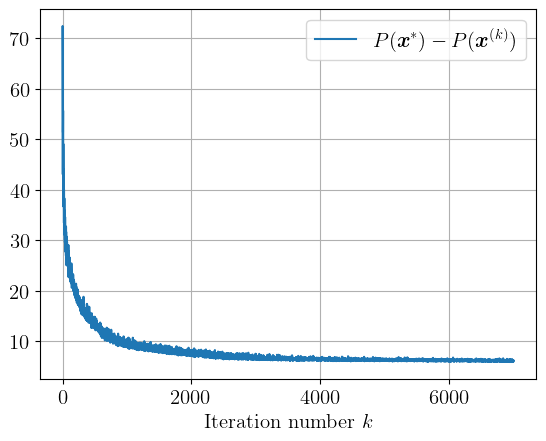

In [8]:
if __name__ == "__main__":
    from matplotlib.ticker import MultipleLocator

    fig2, ax2 = plt.subplots()

    err = sum(data[i]["f_i"] for i in NODES) - opt_val

    ax2.plot(err, label=r"$P(\boldsymbol{x}^*)-P(\boldsymbol{x}^{(k)})$")

    ax2.set_xlabel("Iteration number $k$")
    ax2.yaxis.set_major_locator(MultipleLocator(10))
    ax2.grid(True)
    ax2.legend()

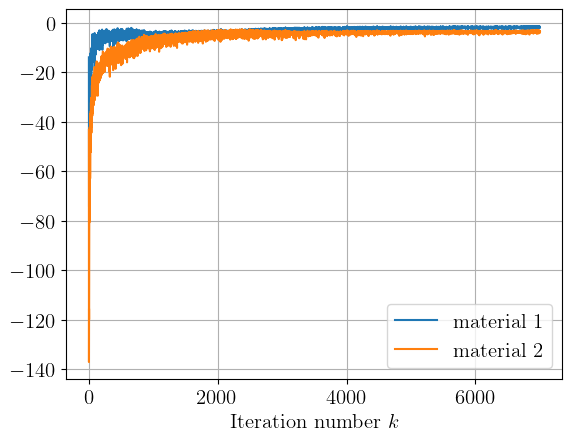

In [9]:
if __name__ == "__main__":
    fig3, ax3 = plt.subplots()

    constraint_values: NDArray[np.float64] = (
        sum([A_mat[i] @ data[i]["x_i"].T for i in NODES]) - b_mat[:, np.newaxis]
    )

    for i in range(constraint_values.shape[0]):
        ax3.plot(constraint_values[i], label=f"material {i + 1}")

    ax3.set_xlabel("Iteration number $k$")
    ax3.grid(True)
    ax3.legend()

    plt.show()